# Travaux pratiques de problèmes inverses en génie civil



Vous êtes un(e) doctorant(e) intelligent(e), pleins d'avenir. On vous demande de déterminer le modèle dynamique du compateur. 
Les équations sont : 

$$ Force = M \gamma + F_v v + F_s + 2 ZZ \ddot{q} $$

 $\gamma$ est l'accélération du centre de gravité. $v$ est la vitesse du compacteur. $\ddot{q}$ est l'accélération articulaire. Les paramètres inconnus sont :
* $M$, la masse  du compacteur.
* $F_v$, le frottement visqueux
* $F_s$, le frottement sec
* $ZZ$ l'inertie de la bille avant qui est égale à l'inertie de la ville arrière


Le chef de chantier vous fournit 

* $\Gamma$ le couple mesuré (appelé couple_mesuré dans le code python)

* $q$ la vitesse articulaire (appelé q)

* $r$ le rayon des roues (appel r)

échantilllonné à 100 Hz (T=0,01s) sur une trajectoire usuelle du compacteur.

A partir de ces informations, trouver $M$, $F_v$, $F_s$, $ZZ$

In [1]:
import numpy as np
from experiences import experience1
couple_mesure, q, T, r = experience1()


Facile !

Contruire le problème inverse : 

$Force = \left(\gamma \ v \ 1 \  \ddot{q} \right)\cdot \left( \begin{array}{c} M \\ Fv \\ F_S \\ ZZ \end{array} \right) + b$

b est un bruit. 

Le problème est sous la forme
$$ Y =W \cdot X + b$$

si le bruit est normal, l'estimateur sans biais de variance minimal est 

$$ \hat{X} = (W^tW)^{-1}W^tY$$

Il faut calculer W et donc, $v$, $\gamma$. Nous utilisons
$$ v = r\dot{q}$$
$$ \gamma=r\ddot{q}$$
$$ Forcel=r\Gamma$$

Pour calculer $dot{q}$ et $\ddot{q}$, nous faisons une différence finie centrée autant de fois que  nécessaire en suivant le schéma numérique suivant.

$$ dx(n) =  \frac{x(n+1)-x(n-1)}{2T}$$

dx est la dérivée numérique de x.

In [2]:
# calcul des vitesses et accélération d
dq=(q[2:]-q[:-2])/(2*T)
ddq=(dq[2:]-dq[:-2])/(2*T)

# tous les signaux sont mis à la même taille
dq=dq[1:-1]
couple_mesure = couple_mesure[2:-2]

In [3]:
# calcul de W et Y
W = np.transpose([r*ddq, r*dq,np.ones(np.size(dq)), 2*ddq])
Y=np.transpose(couple_mesure/r)
#

In [4]:
# résolution par moindres carrés
# nous utilisons la librairie linalg
X=np.linalg.lstsq(W,Y)[0]

In [5]:
np.size(Y)

5997

In [6]:
print('La masse du compacteur est {:.10f}'.format(
      X[0]))
print('Le frottement visqueux {:.10f}'.format(
      X[1]))
print('Le frottement sec est {:.10f}'.format(
      X[2]))
print('L'' inertie des billes est  {:.10f}'.format(
      X[3]))


La masse du compacteur est 1022.7055891014
Le frottement visqueux 100.0886442228
Le frottement sec est 980.9754231561
L inertie des billes est  3030.2387825227


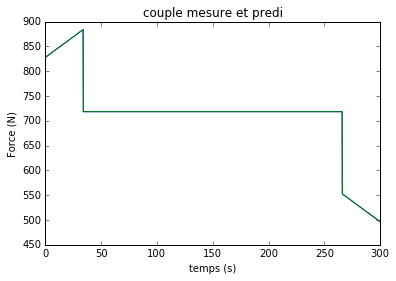

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 
couple_predit=np.transpose(W.dot(X))*r

nech=np.size(Y)
temps=T*np.arange(1,nech+1)
plt.figure(1)
plt.plot(temps, couple_mesure, temps, couple_predit)
plt.title('couple mesure et predi')
plt.xlabel('temps (s)')
plt.ylabel('Force (N)')

np.shape(couple_mesure)

In [8]:
# calcul de W et Y
W = np.transpose([r*ddq, r*dq,np.ones(np.size(dq))])
Y=np.transpose(couple_mesure/r)
#

In [9]:
# résolution par moindres carrés
# nous utilisons la librairie linalg
X=np.linalg.lstsq(W,Y)[0]

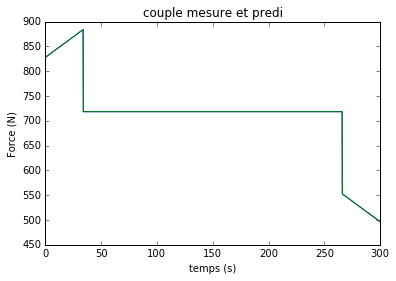

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline 
couple_predit=np.transpose(W.dot(X))*r

nech=np.size(Y)
temps=T*np.arange(1,nech+1)
plt.figure(1)
plt.plot(temps, couple_mesure, temps, couple_predit)
plt.title('couple mesure et predi')
plt.xlabel('temps (s)')
plt.ylabel('Force (N)')

In [11]:
print('La masse du compacteur est {:.10f}'.format(
      X[0]))
print('Le frottement visqueux {:.10f}'.format(
      X[1]))
print('Le frottement sec est {:.10f}'.format(
      X[2]))

La masse du compacteur est 10001.1908706503
Le frottement visqueux 100.0886442228
Le frottement sec est 980.9754231561


In [12]:
np.shape(Y)

(5997,)

In [ ]:
X[0]*r